In [334]:
# Import the necessary libraries that will be used in this code - pandas for data manipulation, numpy for numerical calculations, and seaborn for data visualization. The collections library is also imported to use the Counter function.
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error, roc_auc_score

In [335]:
# load dataset
data = pd.read_csv("Resources/online_shoppers_intention.csv")
df = data.copy()

In [336]:
# display top 5 rows of the dataset
df.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Number of true (customer ended shopping) and false (customer ended not shopping) revenue (Bar Chart).

/Users/petertran/opt/anaconda3/envs/dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Revenue', ylabel='count'>

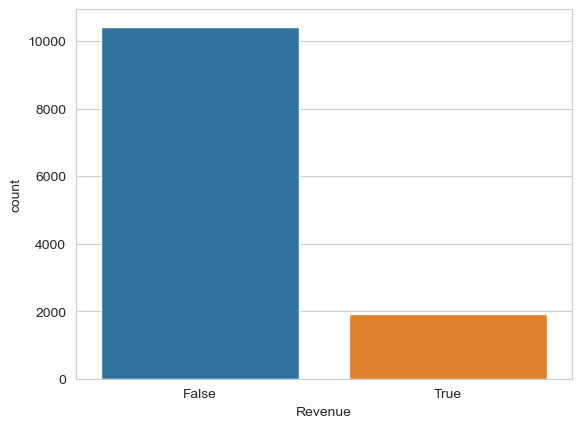

In [337]:
# Visualize distribution of revenue
sns.countplot(df['Revenue'])

In [338]:
# Encode non-numeric columns using OrdinalEncoder
non_numeric_columns = 'Month', 'VisitorType', 'Weekend', 'Revenue'
encoder = OrdinalEncoder()

for col in non_numeric_columns:
    df[col] = encoder.fit_transform(df[[col]])

In [339]:
# split data into train and test sets
X_data = df.drop('Revenue', axis=1)
y_data = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [340]:
# Train a random forest regressor to determine feature importances
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

# Get the top 10 features based on their importances
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
labels = X.columns[indices]


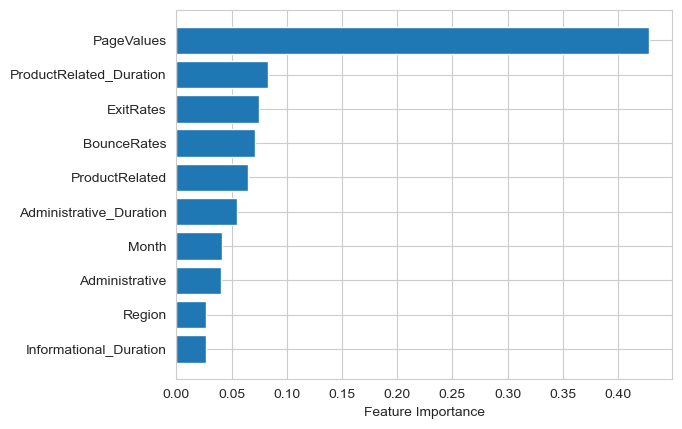

In [341]:
# Plot the top 10 features
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), labels)
plt.xlabel('Feature Importance')
plt.show()



In [342]:
# Train a random forest classifier using the top 10 features
X_train_top10 = X_train[labels]
X_test_top10 = X_test[labels]


## Linear Model with All Features

In [343]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(9864, 17) (2466, 17)
(9864,) (2466,)


In [344]:
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
1785,0,0.0,0,0.0,7,95.000000,0.014286,0.061905,0.000000,0.0,5.0,2,6,1,1,2.0,0.0
10407,2,14.0,0,0.0,81,1441.910588,0.002469,0.013933,2.769599,0.0,7.0,2,2,3,2,2.0,0.0
286,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,5.0,2,2,1,1,2.0,0.0
6520,5,49.2,4,379.0,5,74.600000,0.000000,0.018182,8.326728,0.0,9.0,2,2,8,2,0.0,0.0
12251,0,0.0,1,5.0,9,279.000000,0.040000,0.041667,0.000000,0.0,7.0,3,2,7,8,0.0,1.0


### Number of true (customer ended shopping) and false (customer ended not shopping) revenue (Bar Chart).

/Users/petertran/opt/anaconda3/envs/dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Revenue', ylabel='count'>

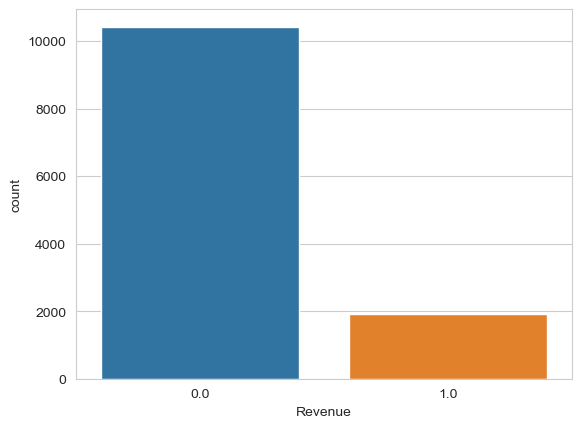

In [345]:

sns.countplot(df['Revenue'])

### •	Distribution of revenue over months.
The resulting bar plot shows the distribution of revenue over the months. The x-axis represents the months, and the y-axis represents the count of instances for each month. The bars are color-coded to show the revenue column's value, with blue representing False (no revenue) and orange representing True (revenue). The plot provides an easy-to-read visualization of the distribution of revenue over the months, allowing for easy comparison between the different months.

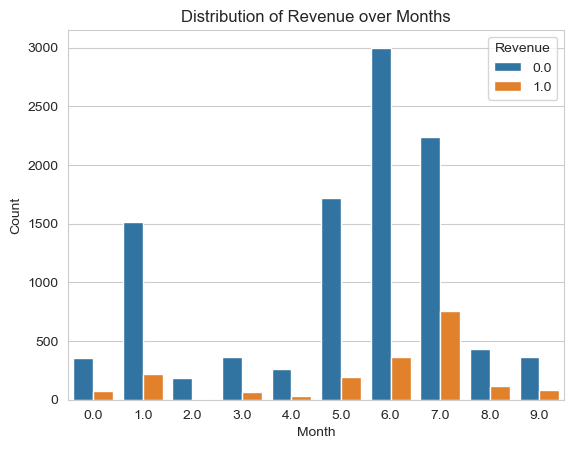

In [346]:

revenue_df = df.sort_values('Month')

# Set the style of the plot
sns.set_style("whitegrid")

# Create a barplot of the revenue distribution over months
sns.countplot(x="Month", hue="Revenue", data=df)

# Add labels to the plot
plt.title("Distribution of Revenue over Months")
plt.xlabel("Month")
plt.ylabel("Count")

# Show the plot
plt.show()


### Distribution of revenue over traffic type.
In this case, we are using the mean revenue for each traffic type because the traffic types are represented as numerical values without any meaningful labels.

If we had meaningful labels for the traffic types, we could use a count plot to show the number of occurrences of each traffic type for each revenue value (i.e., True or False). However, since we don't have labels for the traffic types, we can't use a count plot in this case. Instead, we can use the mean revenue for each traffic type as a proxy for the revenue generated by each traffic type.

For example, if we have 100 instances of traffic type 1 with a revenue value of True and 50 instances of traffic type 1 with a revenue value of False, the mean revenue for traffic type 1 would be (100 * 1 + 50 * 0) / (100 + 50) = 0.67. This mean value represents the average revenue generated by traffic type 1. We can then compare this mean revenue value to the mean revenue values for other traffic types to gain insight into which traffic types generate the most revenue on average.

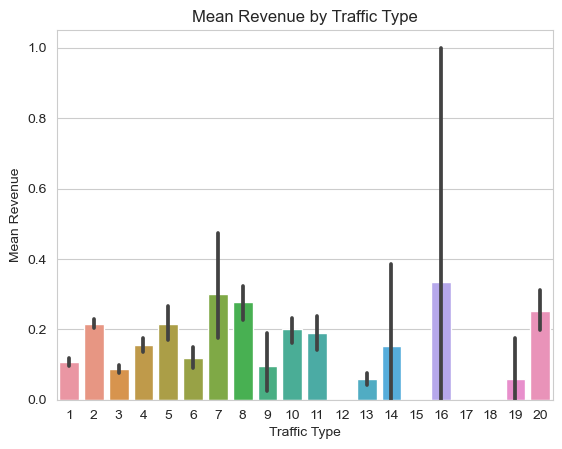

In [347]:
sns.barplot(x="TrafficType", y="Revenue", data=df)
plt.title("Mean Revenue by Traffic Type")
plt.xlabel("Traffic Type")
plt.ylabel("Mean Revenue")
plt.show()


### Distribution of revenue over special day.
The code below uses the seaborn library to create a swarm plot of the distribution of revenue over the "SpecialDay" feature.

A swarm plot is a type of categorical scatter plot that displays the distribution of data points for each category along an axis. In this case, the "SpecialDay" values are shown along the x-axis, and the revenue values are shown along the y-axis. Each point on the plot represents a single data point from the dataset, with its location on the x-axis corresponding to its "SpecialDay" value and its location on the y-axis corresponding to its revenue value (0 or 1).

By using different colors for the revenue values, we can easily see how the distribution of revenue changes for each "SpecialDay" value. In this plot, orange points represent revenue=1, while blue points represent revenue=0.

The plot provides useful information about the relationship between the "SpecialDay" feature and the revenue outcome. For example, we can see that on special days (SpecialDay values of 0.4, 0.6, and 0.8), there are fewer instances of revenue=1 than on non-special days (SpecialDay values of 0.0 and 1.0). This could suggest that customers are less likely to make purchases on special days, or that the website is less effective at converting visitors into customers on these days. However, it's important to keep in mind that this plot only shows correlation, and not causation.

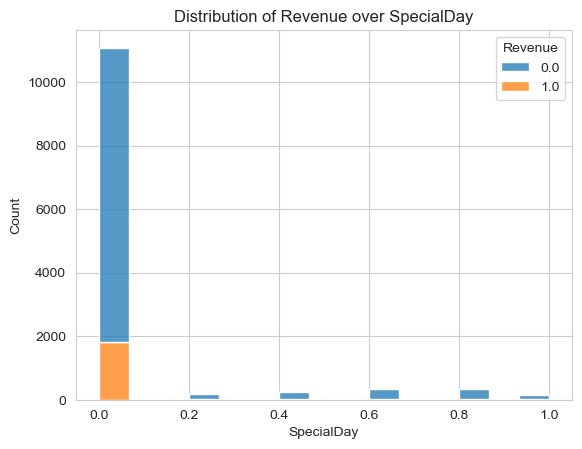

In [348]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a histogram of the revenue distribution over SpecialDay
sns.histplot(x="SpecialDay", hue="Revenue", data=df, multiple="stack")

# Add labels to the plot
plt.title("Distribution of Revenue over SpecialDay")
plt.xlabel("SpecialDay")
plt.ylabel("Count")

# Show the plot
plt.show()


In [349]:
result_dict = {}
# Helper function to summarize
def summarize_classification(y_test,y_pred):
    """
    As it's take the actual target labels of the test set and predicted label.
    and will Give the summary of the Goodness of fit of the mode on the Validation/test dataset.
    """
    acc = accuracy_score(y_test,y_pred,normalize=True)
    num_acc = accuracy_score(y_test,y_pred,normalize=False)
    
    prec = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1_score =  f1_score(y_test,y_pred)
    auc_score = roc_auc_score(y_test,y_pred)
    
    
    return{'Accuracy:': acc,
           'Accuracy_count:': num_acc,
           'Precision:': prec,
           'Recall:': recall,
           'F1_score:':F1_score,
           'AUC_ROC:':auc_score}

## Building a Base Model

In [350]:
# Helper function to Build Model
def build_model(classifier_fn,
                model_type,
                name_of_y_col,
                name_of_x_cols,
                dataset,
                test_frac=0.2):
  
    """
    Builds end to end model and share the model summary.
    if show_plot_auc==True : Plot the AUC - ROC curve.
    """ 
    
    # Separating the  input features (X) and target variable (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue']

    # feature Scaling
    scale_x = StandardScaler()
    x = scale_x.fit_transform(X)
    
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    
    if model_type == 'knn':
        model = classifier_fn(x_train, y_train)
    elif model_type == 'random_forest':
        model = classifier_fn(x_train, y_train)
    elif model_type == 'dnn':
        model = classifier_fn(x_train, y_train, input_dim=X.shape[1])
    else:
        raise ValueError("Invalid model_type")
    
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)

    y_pred_train = (y_pred_train > 0.5).astype(int)
    train_summary = summarize_classification(y_train, y_pred_train)
    y_pred = (y_pred > 0.5).astype(int)
    test_summary = summarize_classification(y_test, y_pred)
    
    pred_result = pd.DataFrame({'y_test':y_test,
                                'y_pred':y_pred.reshape(-1,)
                                })
    
    model_crosstab = pd.crosstab(pred_result.y_pred,pred_result.y_test)
    
    # store the result
    return{'training':train_summary,
          'test':test_summary,
          'confusion_matrix':model_crosstab
          }


## Compare Results

In [351]:
# Helper function to compare the score of different Model.    
def compare_result():
    """
    Shows Train the Test data summary for the all the Model runned in form of data dictionary.
    """
    for key in result_dict:
        print('Classification: ',key)
        
        print()
        print('Training data:-')
        for score in result_dict[key]['training']:
            print(score,result_dict[key]['training'][score])
            
        print()
        print('Test Data:-')
        for score in result_dict[key]['test']:
            print(score,result_dict[key]['test'][score])
            
        print()

## Model 1: Neural Networks

In [352]:
def dnn_fn(X_train, y_train, input_dim=17, output_dim=1):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train,
              epochs=100, batch_size=32, verbose=0)

    return model


In [353]:
result_dict['Revenue ~ DNN'] = build_model(dnn_fn, 'dnn', y, X, df)


## Model 2: Unsupervised Learning - K-Nearest Neighbours (KNN)

In [354]:
def knn_fn(X_train,y_train,n_neighbors=9,random_state=12) -> KNeighborsClassifier:
    """
    Function to buld KNN Model for the given dataset
    """
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train,y_train)
    
    return model


In [355]:
result_dict['Revenue ~ KNN'] = build_model(knn_fn, 'knn', y, X, df)


## Model 3: Supervised Learning - Random Forest Classifier

In [356]:
def random_forest_fn(x_train,y_train) -> RandomForestClassifier:
    """
    Function to buld ensemble model using 50 decision trees for the given dataset
    """
    # create a random forest classifier model
    model = RandomForestClassifier(n_estimators= 50, max_depth = 15,random_state=12 )

    # fit the model to the training data
    model.fit(x_train,y_train)
    
    return model

In [357]:
result_dict['Revenue ~ Random_Forest'] = build_model(random_forest_fn, 'random_forest', y, X, df)


In [358]:
print(compare_result())

Classification:  Revenue ~ DNN

Training data:-
Accuracy: 0.8820965125709651
Accuracy_count: 8701
Precision: 0.8172888015717092
Recall: 0.27994616419919244
F1_score: 0.4170426065162907
AUC_ROC: 0.634422831443115

Test Data:-
Accuracy: 0.8633414436334145
Accuracy_count: 2129
Precision: 0.7814569536423841
Recall: 0.2796208530805687
F1_score: 0.41186736474694585
AUC_ROC: 0.6317380194952746

Classification:  Revenue ~ KNN

Training data:-
Accuracy: 0.8839213300892133
Accuracy_count: 8719
Precision: 0.7846410684474123
Recall: 0.3162853297442799
F1_score: 0.4508393285371702
AUC_ROC: 0.6504439300905692

Test Data:-
Accuracy: 0.85117599351176
Accuracy_count: 2099
Precision: 0.7165354330708661
Recall: 0.2156398104265403
F1_score: 0.33151183970856096
AUC_ROC: 0.5990136429823504

Classification:  Revenue ~ Random_Forest

Training data:-
Accuracy: 0.990977291159773
Accuracy_count: 9775
Precision: 0.9992852037169406
Recall: 0.9407806191117093
F1_score: 0.969150779896014
AUC_ROC: 0.9703306294412687
